<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/bigearthnet%2Fvae/notebooks/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretext Task: VAE

Adpated from: https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@bigearthnet/vae

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision bigearthnet/vae) to /tmp/pip-install-959flj9w/ssl-remote-sensing_51ac1753c87841bab71fca44b3609acb
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-959flj9w/ssl-remote-sensing_51ac1753c87841bab71fca44b3609acb
  Running command git checkout -b bigearthnet/vae --track origin/bigearthnet/vae
  Switched to a new branch 'bigearthnet/vae'
  Branch 'bigearthnet/vae' set up to track remote branch 'bigearthnet/vae' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 329 kB 4.9 MB/s 
     |████████████████████████████████| 20.9 MB 98.4 MB/s 
     |████████████████████████████████| 1.9 MB 60.6 MB

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility, batch_mean_and_sd, imshow, print_model
from ssl_remote_sensing.data.bigearthnet_dataloader import BigearthnetDataModule
from ssl_remote_sensing.data.get_eurosat import get_eurosat_dataloader
from ssl_remote_sensing.models.ResNet18 import resnet18_encoder, resnet18_decoder
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
#from ssl_remote_sensing.downstream_tasks.classification import DownstreamClassificationNet

In [4]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms


# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

from torch import Tensor
from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch.multiprocessing import cpu_count

import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A

Machine setup

In [6]:
# Machine setup
available_gpus = torch.cuda.device_count()
print("available_gpus:", available_gpus)

available_gpus: 1


In [7]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [8]:
import os

In [9]:
from google.colab import drive
drive.mount('/content/drive')
# make sure the directory path exists
# model_dir = '/content/drive/My Drive/deep_learning_checkpoints'
model_dir = '/content/drive/My Drive/deep_learning_vae_checkpoints'
model_path = os.path.join(model_dir,'vae.ckpt')
#model_path = os.path.join(model_dir,'vae_normalized_eurosat.ckpt')
assert os.path.exists(model_dir)

Mounted at /content/drive


Saved model path setup

## Hyperparameter setup

In [10]:
# Model Setup
class Hparams:
    def __init__(self):
        self.pretext_epochs = 30 # number of training epochs for pretext tasks
        self.seed = 42  # randomness seed
        # self.save = "./saved_models/"
        # self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        # self.weight_decay = 1e-6
        self.latent_dim = 256
        self.optim = "Adam"
        # self.embedding_size = 128  # papers value is 128
        # self.temperature = 0.5  # 0.1 or 0.5
        self.cuda = True  # use coda
        self.transform = True
        self.split = False

In [11]:
train_config = Hparams()

In [12]:
reproducibility(train_config)

In [ ]:
wandb.init(project="ssl-remote-sensing-vae", config=train_config.__dict__)

wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin


## Data

Description: EuroSAT, RGB, Normalized

In [ ]:
# classes = (
#     "AnnualCrop",
#     "Forest",
#     "HerbaceousVegetation",
#     "Highway",
#     "Industrial",
#     "Pasture",
#     "PermanentCrop",
#     "Residential",
#     "River",
#     "SeaLake"
# )

Calculation of mean and sd: https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html

In [ ]:
# means = [0.3444, 0.3803, 0.4078]
# stds = [0.2037, 0.1366, 0.1148]

In [ ]:
# if train_config.transform:

#     transform = transforms.Compose([
#                 transforms.ToTensor(), 
#                 transforms.Normalize(
#                     mean = means,
#                     std = stds) # params computed from the eurosat data
#                 ])
# else:
#     transform = transforms.Compose([
#                   transforms.ToTensor(), 
#                   ])


In [ ]:
# train_loader = get_eurosat_dataloader("./",transform = transform, batchsize = train_config.batch_size , numworkers = cpu_count(), split = False)

In [ ]:
# create Colab Notebooks directory
data_directory = '/content/data/'
if not os.path.exists(data_directory): os.makedirs(data_directory)

In [ ]:
!cp -r /content/drive/MyDrive/bigearthnet.tar.gz /content/data/

In [ ]:
!tar -xf /content/data/bigearthnet.tar.gz 

In [ ]:
dataset_dir = "/content/BigEarthNet-v1.0/"

In [ ]:
from pathlib import Path
import os

import numpy as np
import rasterio
from torch.utils.data import Dataset
import torch
import glob
from rasterio.enums import Resampling


ALL_BANDS = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']


# Stats from https://github.com/ServiceNow/seasonal-contrast/blob/main/datasets/bigearthnet_dataset.py
BAND_STATS = {
    'mean': {
        'B01': 340.76769064,
        'B02': 429.9430203,
        'B03': 614.21682446,
        'B04': 590.23569706,
        'B05': 950.68368468,
        'B06': 1792.46290469,
        'B07': 2075.46795189,
        'B08': 2218.94553375,
        'B8A': 2266.46036911,
        'B09': 2246.0605464,
        'B11': 1594.42694882,
        'B12': 1009.32729131
    },
    'std': {
        'B01': 554.81258967,
        'B02': 572.41639287,
        'B03': 582.87945694,
        'B04': 675.88746967,
        'B05': 729.89827633,
        'B06': 1096.01480586,
        'B07': 1273.45393088,
        'B08': 1365.45589904,
        'B8A': 1356.13789355,
        'B09': 1302.3292881,
        'B11': 1079.19066363,
        'B12': 818.86747235
    }
}


def normalize(img, mean, std):
    min_value = mean - 2 * std
    max_value = mean + 2 * std
    img = (img - min_value) / (max_value - min_value) * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img


class Bigearthnet(Dataset):

    def __init__(self, dataset_dir, bands=ALL_BANDS, transform=None):
        self.bands = bands
        self.transform = transform
        self.samples = glob.glob(os.path.join(dataset_dir, "*"))
        self.image_size = 120


    def __getitem__(self, index):
        path = self.samples[index]
        patch_id = path.split("/")[-1]

        channels = []
        for b in self.bands:
            ch = rasterio.open(Path(path, f'{patch_id}_{b}.tif')).read(
                1,
                out_shape=(
                        1,
                        self.image_size, 
                        self.image_size
                    ),
                resampling=Resampling.bilinear
                )
            ch = normalize(ch, mean=BAND_STATS['mean'][b], std=BAND_STATS['std'][b])
            channels.append(ch)   
        img = np.dstack(channels)
        img = torch.from_numpy(img)
        img = torch.permute(img, (2, 0, 1))

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.samples)

In [ ]:

from torchvision import transforms
from pytorch_lightning import LightningDataModule

from ssl_remote_sensing.data.bigearthnet_dataset import Bigearthnet
from torch.utils.data import DataLoader

ALL_BANDS = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

class BigearthnetDataModule(LightningDataModule):

    def __init__(self, data_dir, bands=ALL_BANDS, batch_size=32, num_workers=16, seed=42, train_transforms=None):
        super().__init__()
        self.data_dir = data_dir
        self.bands = bands
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.train_dataset = None
        self.train_transforms = train_transforms

    def setup(self):
        train_transforms = self.train_transform() if self.train_transforms is None else self.train_transforms

        self.train_dataset = Bigearthnet(
            dataset_dir=self.data_dir,
            #bands=self.bands,
            transform=train_transforms
        )

    @staticmethod
    def train_transform():
        return transforms.Compose([
            transforms.RandomCrop(64),
            #transforms.ToTensor()
        ])

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )


In [ ]:
datamodule = BigearthnetDataModule(data_dir = dataset_dir, batch_size=train_config.batch_size, num_workers = 1,seed= train_config.seed)

In [ ]:
datamodule.setup()

In [ ]:
train_loader = datamodule.train_dataloader()

In [ ]:
next(iter(train_loader)).shape

torch.Size([16, 12, 64, 64])

### Plot images

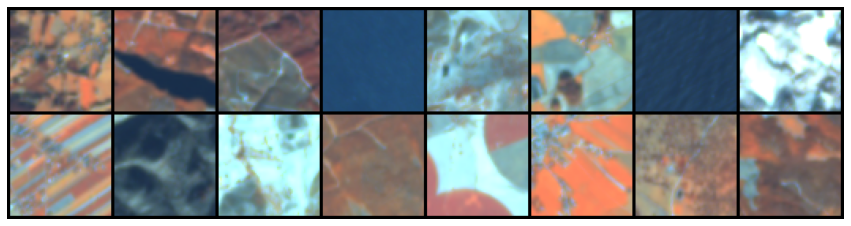

In [ ]:
dataiter = iter(train_loader)
images = next(dataiter)
img_list = []
for image in images:
  img = image[[5, 4, 3], :, :]
  img_list.append(img)
 
def show(img):
    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

grid = torchvision.utils.make_grid(img_list, nrow=8)
show(grid)

## Model setting

In [ ]:
# ResNet18 model
# copied from https://github.com/Lightning-AI/lightning-bolts/blob/master/pl_bolts/models/autoencoders/components.py

import torch
from torch import nn
import torch.nn.functional as F
import functools
import torch.utils.model_zoo as model_zoo


class Interpolate(nn.Module):
    """nn.Module wrapper for F.interpolate."""

    def __init__(self, size=None, scale_factor=None):
        super().__init__()
        self.size, self.scale_factor = size, scale_factor

    def forward(self, x):
        return F.interpolate(x, size=self.size, scale_factor=self.scale_factor)


class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def resize_conv3x3(in_planes, out_planes, scale=1):
    """upsample + 3x3 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv3x3(in_planes, out_planes)
    return nn.Sequential(
        Interpolate(scale_factor=scale), conv3x3(in_planes, out_planes)
    )


def resize_conv1x1(in_planes, out_planes, scale=1):
    """upsample + 1x1 convolution with padding to avoid checkerboard artifact."""
    if scale == 1:
        return conv1x1(in_planes, out_planes)
    return nn.Sequential(
        Interpolate(scale_factor=scale), conv1x1(in_planes, out_planes)
    )


class EncoderBlock(nn.Module):
    """ResNet block, copied from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L35."""

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class DecoderBlock(nn.Module):
    """ResNet block, but convs replaced with resize convs, and channel increase is in second conv, not first."""

    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None):
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetEncoder(nn.Module):
    def __init__(self, block, layers):
        super().__init__()

        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            12, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Sequential()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # x = self.fc(x)
        return x


class ResNetDecoder(nn.Module):
    """Resnet in reverse order."""

    def __init__(self, block, layers, latent_dim, input_height):
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.input_height = input_height

        self.upscale_factor = 8

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=2)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)
        self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
        self.upscale_factor *= 2
        self.upscale = Interpolate(scale_factor=2)
        self.upscale_factor *= 2

        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(
            64 * block.expansion, 12, kernel_size=3, stride=1, padding=1, bias=False
        )

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        x = self.upscale1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.upscale(x)

        x = self.conv1(x)
        return x


# encoder
def resnet18_encoder():
    return ResNetEncoder(EncoderBlock, [2, 2, 2, 2])

# decoder
def resnet18_decoder(latent_dim, input_height):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height)

In [ ]:
import torch
import torch.nn as nn
# from ssl_remote_sensing.models.ResNet18 import resnet18_encoder, resnet18_decoder


class VariationalAutoencoder(nn.Module):
    def __init__(self, enc_out_dim=512, latent_dim=None, input_height=64, config=None):
        super().__init__()

        self.encoder = resnet18_encoder()
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, input_height=input_height
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self, config):
        # set optimizer
        if config.optim == "Adam":
            # set learning rate
            return torch.optim.Adam(self.parameters(), lr=config.lr)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = log_qzx - log_pz
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch):
        x = batch
        x = x.float()

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = kl - recon_loss
        elbo = elbo.mean()

        return x_encoded, x_hat, elbo


In [ ]:
# set latent dimension
d  = train_config.latent_dim

# create model
model =  VariationalAutoencoder(latent_dim = d, config = train_config)
# model has been moved to device
model =  model.to(device)
print("[LOG] Latent dimension for VAE is: ", d)

[LOG] Latent dimension for VAE is:  256


## Training

In [ ]:
# check if model is on cuda
print("[LOG] Is model on cuda? ", next(model.parameters()).is_cuda)

[LOG] Is model on cuda?  True


In [ ]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 20102401.


In [ ]:
model_path

'/content/drive/My Drive/deep_learning_vae_checkpoints/vae.ckpt'

In [ ]:
# Training and testing the VAE

epochs = train_config.pretext_epochs
train_losses = []

for epoch in range(1, epochs+1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        # for y, _ in train_loader:
        for y in train_loader:
            y = y.to(device)
            # ===================forward=====================
            loss = model.training_step(y)[2]
            train_loss += loss.item()/ len(train_loader)

            # ===================backward====================
            model.configure_optimizers(config = train_config).zero_grad()
            loss.backward()
            model.configure_optimizers(config = train_config).step()
        wandb.log({'train_epoch_loss_vae': train_loss})
         # ===================log =====================
        print(f'====> Epoch: {epoch}/{epochs} Average training loss: {train_loss :.4f}')
        train_losses.append(train_loss)
        # ===================image log =====================
        # imgs = sample_images.to(device)
        # decoded_imgs = model.training_step(imgs)[1]
        # imshow(decoded_imgs)
        # decoded_imgs = decoded_imgs[[5, 4, 3], :, :]
        # # reconstruct only 1 image as sample image
        # decoded_imgs = np.transpose(decoded_imgs.cpu().data.numpy()[0], (1, 2, 0))
        # image_epoch = wandb.Image(decoded_imgs, caption="Generated image")
        # wandb.log({"examples": image_epoch})
        
        # # Specify you are in evaluation mode
        # model.eval()
        # with torch.no_grad():
        #     val_loss = 0
        #     for y,_ in val_loader:
        #         y = y.to(device)
        #         # labels = labels.to(device)
        #         # calculate outputs by running images through the network
        #         output = model.training_step(y)[2]
        #         val_loss += output.item()/ len(val_loader)
        #         # the class with the highest energy is what we choose as prediction
        #         # collect mini-batch reconstruction loss
        #     # ===================log========================
        # print(f'====> Epoch: {epoch} Average training loss: {train_loss :.4f} Average validation loss: {val_loss :.4f}')

        #save_weights_path = os.path.join(save_model_path,'autoencoder.ckpt')
        torch.save(model.state_dict(),model_path)
        print('Saving Model to Google Drive: ', model_dir)
        # backup saving to vm dir
        # torch.save(model.state_dict(),os.path.join('./saved_models', 'autoencoder.ckpt'))

        # if epoch == 1:
        #   # best_val_loss = val_loss
        #   best_val_loss = train_loss
        # else:
        #   # if val_loss <= best_val_loss:
        #   if train_loss <= best_val_loss:
        #       best_val_loss = train_loss
        #       # best_val_loss = val_loss
        #       # Save only the best model
        #       save_weights_path = os.path.join(save_model_path,'autoencoder.ckpt')
        #       torch.save(model.state_dict(), save_weights_path)
        #       print('Saving Model...')
          
print('Finished Training')

====> Epoch: 1/30 Average training loss: 7232924.8704
Saving Model to Google Drive:  /content/drive/My Drive/deep_learning_vae_checkpoints
====> Epoch: 2/30 Average training loss: 231217.6982
Saving Model to Google Drive:  /content/drive/My Drive/deep_learning_vae_checkpoints
====> Epoch: 3/30 Average training loss: 227007.3906
Saving Model to Google Drive:  /content/drive/My Drive/deep_learning_vae_checkpoints
====> Epoch: 4/30 Average training loss: 224473.0329
Saving Model to Google Drive:  /content/drive/My Drive/deep_learning_vae_checkpoints
====> Epoch: 5/30 Average training loss: 222408.7302
Saving Model to Google Drive:  /content/drive/My Drive/deep_learning_vae_checkpoints
====> Epoch: 6/30 Average training loss: 220709.7757
Saving Model to Google Drive:  /content/drive/My Drive/deep_learning_vae_checkpoints
====> Epoch: 7/30 Average training loss: 218989.9541
Saving Model to Google Drive:  /content/drive/My Drive/deep_learning_vae_checkpoints
====> Epoch: 8/30 Average trainin

KeyboardInterrupt: ignored

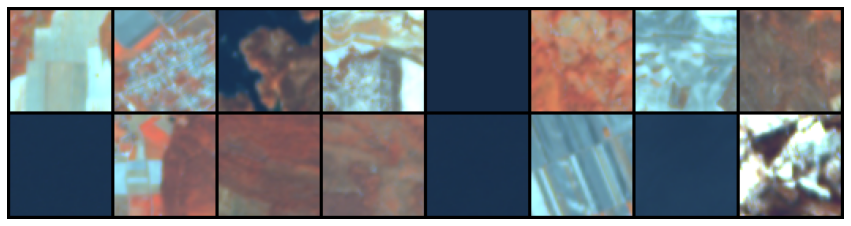

In [ ]:
dataiter = iter(train_loader)
images = next(dataiter)
img_list = []
for image in images:
  img = image[[5, 4, 3], :, :]
  img_list.append(img)
 
def show(img):
    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# print(img_list)

grid = torchvision.utils.make_grid(img_list, nrow=8)
show(grid)

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_path)))

<All keys matched successfully>

In [ ]:
decoded_imgs = model.training_step(images.to(device))[1]

In [ ]:
decoded_imgs.shape

torch.Size([16, 12, 64, 64])

In [ ]:
images

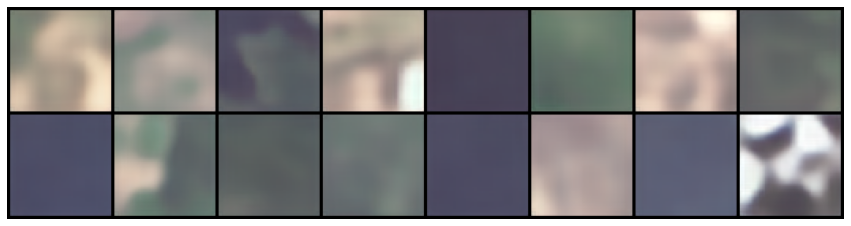

In [ ]:
decoded_imgs = model.training_step(images.to(device))[1]
img_list = []
for image in decoded_imgs:
  img = image[[3, 2, 1], :, :]
  img_list.append(img)
# print(img_list)
grid = torchvision.utils.make_grid(img_list, nrow=8)
def show(img):
    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.axis('off')
    npimg = img.to("cpu").numpy().astype(int)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
show(grid)